# PyTCR - Example 3: Tropical cyclone maximum wind speed

**Author:** [Phong Le](https://github.com/levuvietphong)

**Description:** This notebook provides an analysis and visualization of the maximum wind speed generated by tropical cyclones. It builds upon the methodology used in Example 2, with a specific focus on wind speed data. The notebook includes data loading, processing, and plotting steps to analyze the wind speed patterns associated with tropical cyclones.  

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import colorcet as cc

import tcr.datadir as tcr_data
import tcr.rainfall as tcr_rain
import tcr.wind as tcr_wind
import tcr.iodata as tcr_io
import tcr.convert as tcr_convert
import tcr.plots as tcr_plot

### Configuration for Mapping and Plotting

In [2]:
# Mapping boundary and projection
xmin = -115; xmax = -45
ymin = 12; ymax = 48
extent = [xmin, xmax, ymin, ymax]
projection = ccrs.AzimuthalEquidistant(central_longitude=-80, central_latitude=30)

# Shapefile
fnCONUS = os.path.join(tcr_data.DATA_DIR, 'shapefiles/CONUS.shp')
shpCONUS = shpreader.Reader(fnCONUS)

# Plotting period
yearmin = 1964
yearmax = 2014
num_years = yearmax - yearmin + 1

# Directory containing the downscaled data
data_directory = os.path.join(tcr_data.DATA_DIR, 'downscaled')


### Load data from a CMIP6 model
In this notebook, the [E3SM version 1.0](https://e3sm.org/) is demonstrated but the notebook is applicable to other [CMIP6 models](https://pcmdi.llnl.gov/CMIP6/).

In [3]:
model='E3SM-1-0'
expmnt='historical'

# Load NetCDF data
ds, lat_trks, lon_trks, n_trk, v_trks, vmax_trks, u850_trks, v850_trks, \
    tc_month, tc_years, tc_time = tcr_io.load_netcdf_track_data(
    data_directory=data_directory, model=model, basin='NA', expmnt=expmnt)

### Estimate the radius of the tropical cyclone based on circular wind speed.
- The downscaling model does not provide the radius of maximum circular wind.
- We will estimate it using the wind speed only once and save it to the dataset.
- If the radius is already in the dataset, we will load it.


In [4]:
rm_trks = tcr_wind.estimate_radius_wind(
    ds, lat_trks, vmax_trks, n_trk, data_directory=data_directory, 
    model=model, basin='NA', expmnt=expmnt, force_recompute=False
)

The radius of maximum circular wind was found in file!
Loading rm_trks...


### Calculate the spatial distribution of accumulated precipitation for a given individual storm.

In [5]:
gl_storm_id = 913
[ut, vt, uinc, vinc] = tcr_wind.get_translation_speeds_full(lat_trks, lon_trks, vs=v_trks, u850=u850_trks, v850=v850_trks)
[x, y, windspeed] = tcr_wind.calculate_wind_swath(gl_storm_id, lat_trks, lon_trks, rm_trks, v_trks, 0.2*rm_trks, 0.2*v_trks, uinc, vinc)

### Visualization

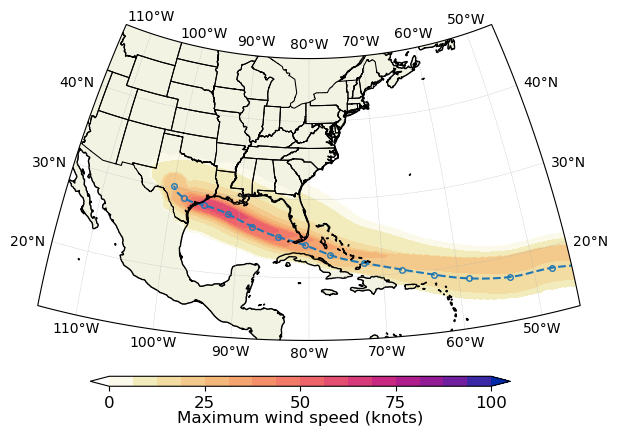

In [6]:
cmap = cc.cm.CET_L17
max_wind_level = 100 # knots
levels = np.linspace(0, max_wind_level, 17)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="w", subplot_kw=dict(projection=projection))

# PLOT Net Rainfall
windspeed = np.ma.masked_where(windspeed<5, windspeed)
im = tcr_plot.plot_density(ax, y, x, windspeed, levels, extent=extent, projection=projection,
                           alpha=1, cmap=cmap, gridlabel=True, gridspace=10, shapefile=shpCONUS)

# Filter points with positive wind speed
ind_trk = np.where(v_trks[gl_storm_id, :] > 0)[0]

# Plot the track
ax.plot(lon_trks[gl_storm_id, ind_trk], lat_trks[gl_storm_id, ind_trk], color='tab:blue', ls='--',
        alpha=1, transform=ccrs.PlateCarree(), zorder=1)

# Show dots along the track
ese = np.linspace(0, len(lon_trks[gl_storm_id, ind_trk]) - 1, 15, dtype=int)
ax.plot(lon_trks[gl_storm_id, ese], lat_trks[gl_storm_id, ese], 'o', ms=4, color='tab:blue',
        markerfacecolor='none', alpha=1, transform=ccrs.PlateCarree(), zorder=1)

# Colorbar
cbax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Maximum wind speed (knots)', fontsize=12, labelpad=0)
cb.set_ticks(np.linspace(0, max_wind_level, 5))
cb.ax.tick_params(labelsize=12)